In [1]:
import Estimate_Covariance_Matrix as ECM
from portfolio_choice_functions import ew_implement
from prepare_portfolio_data import define_important_dates, create_date_ranges
from Main import settings, features, pf_set
import pandas as pd
from datetime import datetime
from pandas.tseries.offsets import MonthEnd
from Prepare_Data import process_risk_free_rate, load_and_filter_market_returns_test, wealth_func
import os
import pickle
import time
import prepare_portfolio_data
import data_run_files
import Estimate_Covariance_Matrix
import Prepare_Data
import portfolio_choice_functions
from portfolio_choice_functions import w_fun, m_func
import portfolio_choice_functions
import numpy as np
from dateutil.relativedelta import relativedelta
import importlib
import General_Functions
sqrtm_cpp = importlib.import_module("sqrtm_cpp")

import os
import pandas as pd
import pyreadr


Features list length: 154


In [2]:


# Sti til din base-mappe
base_path = "./data_test/"
# Hent liste over undermapper/filer



# Læs CSV-filen med pandas
bm_pfs = pd.read_csv(os.path.join(base_path, "bms.csv"))

# Konverter eom_ret til dato
bm_pfs['eom_ret'] = pd.to_datetime(bm_pfs['eom_ret'])

# Erstat "Rank-Weighted" med "Rank-ML" i kolonnen type
bm_pfs.loc[bm_pfs['type'] == 'Rank-Weighted', 'type'] = 'Rank-ML'


In [3]:
bm_pfs["type"].unique()

array(['Markowitz-ML', 'Factor-ML', '1/N', 'Market', 'Rank-ML',
       'Minimum Variance'], dtype=object)

In [4]:
pfs = bm_pfs



In [5]:
pfs

,inv,shorting,turnover,r,tc,eom_ret,type
0,10.245634,4.734082,10.437974,-0.121086,3.659551,2020-01-31,Markowitz-ML
1,9.869913,4.526659,7.987228,-0.124307,1.838792,2020-02-29,Markowitz-ML
2,9.087734,4.223161,6.378685,-0.019131,1.009126,2020-03-29,Markowitz-ML
3,4.521440,2.185952,6.583944,0.039457,0.787049,2020-04-30,Markowitz-ML
4,4.404835,2.145497,3.623036,0.060375,0.272886,2020-05-30,Markowitz-ML
...,...,...,...,...,...,...,...
277,2.397715,0.698857,1.370332,-0.016471,0.086611,2023-07-30,Minimum Variance
278,2.212964,0.606482,1.211197,-0.010146,0.055876,2023-08-31,Minimum Variance
279,2.124317,0.562159,0.928013,-0.036604,0.026001,2023-09-30,Minimum Variance
280,2.110073,0.555036,0.898150,-0.019432,0.031977,2023-10-30,Minimum Variance


In [7]:
import pandas as pd


gamma_rel = pf_set["gamma_rel"]  

# Beregn portefølje-sammenfatningsstatistikker
pf_summary = pfs.groupby("type").agg(
    n=("eom_ret", "count"),  # Antal observationer
    inv=("inv", "mean"),  # Gennemsnitlig investering
    shorting=("shorting", "mean"),  # Gennemsnitlig shorting
    turnover_notional=("turnover", "mean"),  # Gennemsnitlig omsætning (turnover)
    r=("r", lambda x: x.mean() * 12),  # Gennemsnitligt afkast annualiseret
    sd=("r", lambda x: x.std() * (12**0.5)),  # Volatilitet annualiseret
    sr_gross=("r", lambda x: x.mean() / x.std() * (12**0.5) if x.std() > 0 else None),  # Sharpe Ratio før transaktionsomkostninger
    tc=("tc", lambda x: x.mean() * 12),  # Gennemsnitlige transaktionsomkostninger annualiseret
    r_tc=("r", lambda x: (x - pfs.loc[x.index, "tc"]).mean() * 12),  # Nettoafkast efter transaktionsomkostninger
    sr=("r", lambda x: (x - pfs.loc[x.index, "tc"]).mean() / x.std() * (12**0.5) if x.std() > 0 else None),  # Sharpe Ratio efter transaktionsomkostninger
    obj=("r", lambda x: (x.mean() - 0.5 * x.var() * gamma_rel - pfs.loc[x.index, "tc"].mean()) * 12)  # Optimeringsmål
).reset_index()

# Sorter efter type
pf_summary = pf_summary.sort_values(by="type")

# Filtrer pfs til kun at inkludere de relevante typer (main_types skal defineres)
main_types = ["Markowitz-ML", "Factor-ML", "Market", "Rank-ML", "Minimum Variance"]  # Tilpas efter behov
pfs = pfs[pfs["type"].isin(main_types)]
pfs["type"] = pd.Categorical(pfs["type"], categories=main_types, ordered=True)

# Vis resultatet
from IPython.display import display
display(pf_summary)


C:\Users\andre\AppData\Local\Temp\ipykernel_19084\2760832116.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,type,n,inv,shorting,turnover_notional,r,sd,sr_gross,tc,r_tc,sr,obj
0,Markowitz-ML,47,14.624759,7.059826,12.099872,0.134686,0.371549,0.362498,69.611187,-69.476501,-186.991672,-70.166743
1,Factor-ML,47,2.000000,1.000000,2.051815,-0.029966,0.207817,-0.144196,2.142726,-2.172692,-10.454826,-2.388632
2,Market,47,1.000000,0.000000,0.009486,0.118407,0.191524,0.618236,0.000034,0.118373,0.618059,-0.065035
3,Rank-ML,47,0.994220,0.497110,0.619369,0.012230,0.050724,0.241102,0.142922,-0.130692,-2.576523,-0.143557
4,Minimum Variance,47,2.572656,0.786328,1.217601,0.058686,0.159680,0.367520,0.575743,-0.517057,-3.238084,-0.644546


In [8]:
import pandas as pd
import numpy as np

# Antag, at du har en DataFrame 'pfs' og en liste med main_types:
main_types = ["Markowitz-ML", "Factor-ML", "Market", "Rank-ML", "Minimum Variance"]

# Konverter 'eom_ret' til datetime
pfs['eom_ret'] = pd.to_datetime(pfs['eom_ret'])

# Udtræk unikke typer
types = pfs['type'].unique()

# Udregn kumulative summer pr. type
pfs['cumret'] = pfs.groupby('type', observed=False)['r'].cumsum()
pfs['cumret_tc'] = (pfs['r'] - pfs['tc']).groupby(pfs['type'], observed=False).cumsum()

# Filtrer 'pfs' for de ønskede typer og vælg de relevante kolonner
ts_data = pfs[pfs['type'].isin(main_types)][['type', 'eom_ret', 'cumret', 'cumret_tc']].copy()

# "Pivot longer" - konverter DataFrame'en fra bredt til langt format
ts_data = ts_data.melt(id_vars=['type', 'eom_ret'],
                       value_vars=['cumret', 'cumret_tc'],
                       var_name='name',
                       value_name='value')

# Opret ekstra rækker med 'eom_ret' sat til månedsafslutningen for den tidligste dato
min_date = pfs['eom_ret'].min()
eom = min_date + pd.offsets.MonthEnd(0)

extra_df = pd.DataFrame({
    'eom_ret': [eom] * (2 * len(types)),
    'type': np.tile(types, 2),
    'value': 0,
    'name': np.concatenate([
        np.repeat("cumret", len(types)),
        np.repeat("cumret_tc", len(types))
    ])
})

# Kombiner de oprindelige data med de ekstra rækker
ts_data = pd.concat([ts_data, extra_df], ignore_index=True)

# Tilføj en ny kolonne 'name_pretty' med pæne navne
mapping = {
    "cumret": "Gross return",
    "cumret_tc": "Return net of TC"
}
ts_data['name_pretty'] = ts_data['name'].map(mapping)
ts_data['name_pretty'] = pd.Categorical(ts_data['name_pretty'],
                                         categories=["Gross return", "Return net of TC"],
                                         ordered=True)
ts_data 

,type,eom_ret,name,value,name_pretty
0,Markowitz-ML,2020-01-31,cumret,-0.121086,Gross return
1,Markowitz-ML,2020-02-29,cumret,-0.245393,Gross return
2,Markowitz-ML,2020-03-29,cumret,-0.264525,Gross return
3,Markowitz-ML,2020-04-30,cumret,-0.225068,Gross return
4,Markowitz-ML,2020-05-30,cumret,-0.164693,Gross return
...,...,...,...,...,...
475,Markowitz-ML,2020-01-31,cumret_tc,0.000000,Return net of TC
476,Factor-ML,2020-01-31,cumret_tc,0.000000,Return net of TC
477,Market,2020-01-31,cumret_tc,0.000000,Return net of TC
478,Rank-ML,2020-01-31,cumret_tc,0.000000,Return net of TC


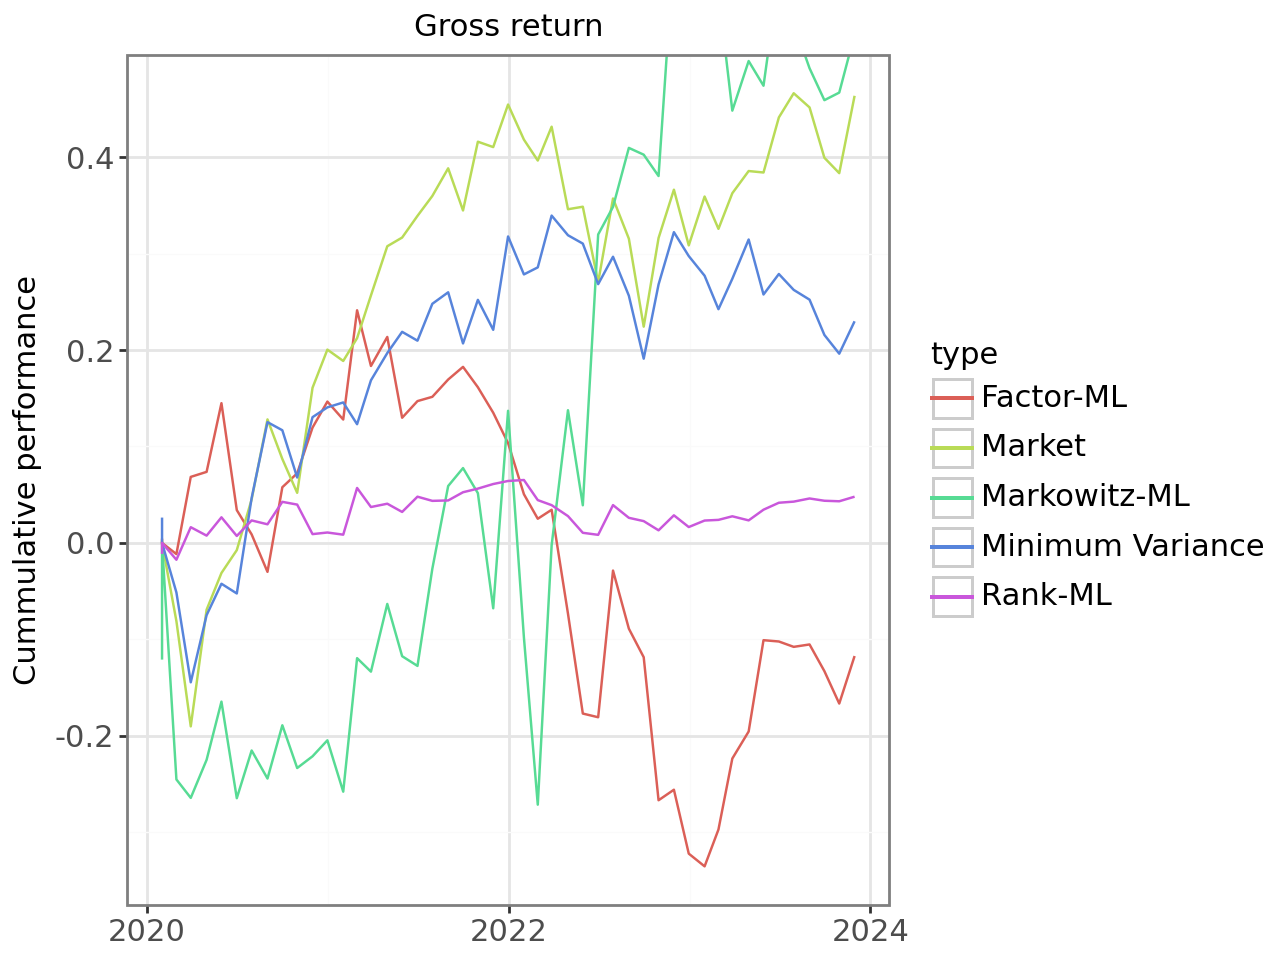

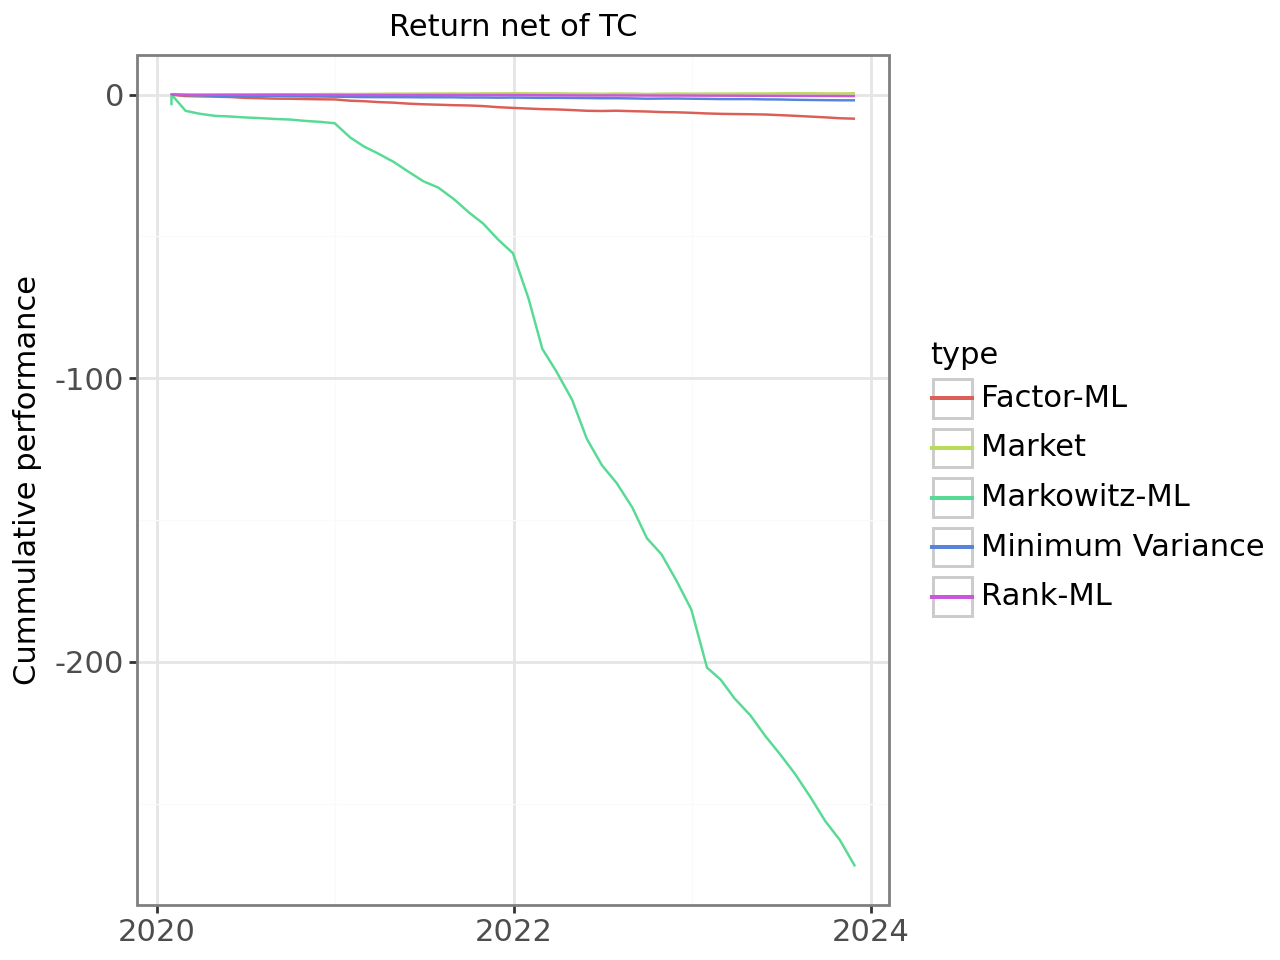

In [9]:
from IPython.display import display
from plotnine import ggplot, aes, geom_line, labs, scale_x_datetime, coord_cartesian, theme_bw, theme, element_text
import pandas as pd

# Antag, at ts_data allerede findes med kolonnerne:
# 'eom_ret', 'value', 'type', 'name' og 'name_pretty'

# Plot for "cumret" (Gross return)
df_cumret = ts_data[ts_data['name'] == 'cumret'].copy()
# Juster y-aksen baseret på data, der ikke er "Markowitz-ML"
df_non_mark = df_cumret[df_cumret['type'] != "Markowitz-ML"]
y_min, y_max = df_non_mark['value'].min(), df_non_mark['value'].max()

plot_cumret = (ggplot(df_cumret, aes(x='eom_ret', y='value', color='type'))
               + geom_line()
               + labs(title="Gross return", y="Cummulative performance", x="")
               + scale_x_datetime(date_labels="%Y")
               + coord_cartesian(ylim=(y_min, y_max))
               + theme_bw()
               + theme(text=element_text(size=11))
              )

# Plot for "cumret_tc" (Return net of TC)
df_cumret_tc = ts_data[ts_data['name'] == 'cumret_tc'].copy()

plot_cumret_tc = (ggplot(df_cumret_tc, aes(x='eom_ret', y='value', color='type'))
                  + geom_line()
                  + labs(title="Return net of TC", y="Cummulative performance", x="")
                  + scale_x_datetime(date_labels="%Y")
                  + theme_bw()
                  + theme(text=element_text(size=11))
                 )

# Vis plottene (hvis du kører i en Jupyter Notebook)
display(plot_cumret)
display(plot_cumret_tc)


# Risk

In [26]:
import pandas as pd
import numpy as np
import os
import pickle
from pandas.tseries.offsets import MonthEnd
from Main import settings, features, pf_set
from datetime import datetime
import portfolio_choice_functions
import General_Functions
import prepare_portfolio_data
import data_run_files
import Estimate_Covariance_Matrix
import Prepare_Data
import Estimate_Covariance_Matrix as ECM
import Prepare_Data
# Path to save the portfolios.
output_path = "./data_test/"


# indhent barra_cov
barra_cov = ECM.main()
# indhent wealth
wealth = Prepare_Data.main()
wealth = wealth.dropna(subset=['wealth'])

chars, lambda_list, first_cov_date, hp_years, start_oos, date_ranges, risk_free = prepare_portfolio_data.main(barra_cov)
dates_m1 = date_ranges["dates_m1"]
dates_m2 = date_ranges["dates_m2"]
dates_oos = date_ranges["dates_oos"]
dates_hp = date_ranges["dates_hp"]


# Benchmark portfolios ------------------------------------------
# Markowitz-ML
tpf = portfolio_choice_functions.tpf_implement(data=chars, cov_list=barra_cov, wealth=wealth, dates=dates_oos, gam=pf_set["gamma_rel"])

# Factor-ML
factor_ml = portfolio_choice_functions.factor_ml_implement(data = chars, wealth = wealth, dates= dates_oos, n_pfs=settings["factor_ml"]["n_pfs"]
 , gam=pf_set['gamma_rel'])

# Market
mkt = portfolio_choice_functions.mkt_implement(data=chars, wealth=wealth, dates=dates_oos, pf_set= pf_set)

# 1/n
ew = portfolio_choice_functions.ew_implement(data=chars, wealth=wealth, dates=dates_oos, pf_set=pf_set)

# Fama-MacBeth / Rank weighted portfolios
rw = portfolio_choice_functions.rw_implement(data=chars, wealth=wealth, dates=dates_oos, pf_set= pf_set)

# Minimum variance
mv = portfolio_choice_functions.mv_implement(data=chars, cov_list=barra_cov ,wealth=wealth, dates=dates_oos, pf_set= pf_set)


All missing excludes 0.60% of the observations
Filen er indlæst og filtreret succesfuldt.
No size screen
Turnover wo addition/deletion rule: 0.19%
Turnover w  addition/deletion rule: 33.72%


Processerer datoer: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 115.08it/s]


Fil indlæst med succes. Antal rækker før filtrering: 1373911
Antal ikke-NaN værdier i 'rvol_252d' i rvol_252 før merge: 2199588
Antal ikke-NaN værdier i 'rvol_252d' i df efter merge: 1353529
      id        eom  rvol_252d
0  10006 1952-08-31   0.012671
1  10006 1952-09-30   0.012712
2  10006 1952-10-31   0.011661
3  10006 1952-11-30   0.011523
4  10006 1952-12-31   0.011812
5  10006 1953-01-31   0.011484
6  10006 1953-02-28   0.011835
7  10006 1953-03-31   0.012331
8  10006 1953-04-30   0.012696
9  10006 1953-05-31   0.013877
Filen 'usa_rvol.parquet' er gemt succesfuldt i ./Data mappen!
Filen er indlæst og filtreret succesfuldt.
All missing excludes 0.60% of the observations
All missing excludes 0.60% of the observations
Filen er indlæst og filtreret succesfuldt.
No size screen
Turnover wo addition/deletion rule: 0.19%
Turnover w  addition/deletion rule: 33.72%
df_merged head:
      eom_ret     id        eom  valid_ret excntry         me   sic size_grp  \
0  1952-09-30  10006 1952-08-3

In [27]:
tpf_w = tpf["w"]
factor_ml_w = factor_ml["w"]
mkt_w = mkt["w"]
ew_w = ew["w"]
rw_w = rw["w"]
mv_w =mv["w"]


In [29]:
barra_cov

{'2017-11-30': {'fct_load':        BusEq  Chems  Durbl  Enrgy  Hlth  Manuf  Money  NoDur  Other  Shops  \
  id                                                                           
  10104    1.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0    0.0    0.0   
  10107    1.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0    0.0    0.0   
  10145    0.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0    1.0    0.0   
  11308    0.0    0.0    0.0    0.0   0.0    0.0    0.0    1.0    0.0    0.0   
  11762    0.0    0.0    0.0    0.0   0.0    1.0    0.0    0.0    0.0    0.0   
  ...      ...    ...    ...    ...   ...    ...    ...    ...    ...    ...   
  91937    0.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0    0.0    0.0   
  92157    1.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0    0.0    0.0   
  92602    0.0    0.0    0.0    0.0   0.0    0.0    0.0    1.0    0.0    0.0   
  92611    0.0    0.0    0.0    0.0   0.0    0.0    1.0    0.0    0.0    0.0   
  92655    0.0

In [12]:
mv_w

,id,eom,w_start,w,tr_ld1,mu_ld1
0,10104,2019-12-31,0.008246,-0.002097,NaN,NaN
1,10104,2020-01-31,-0.002089,0.006524,-0.005238,-0.001351
2,10104,2020-02-29,0.006687,0.015328,-0.056915,-0.079921
3,10104,2020-03-31,0.017387,0.010766,-0.022915,-0.138610
4,10104,2020-04-30,0.010461,0.005417,0.102269,0.134423
...,...,...,...,...,...,...
8079,92655,2023-06-30,0.004197,-0.020180,-0.010165,0.069017
8080,92655,2023-07-31,-0.020501,0.000992,0.053142,0.036647
8081,92655,2023-08-31,0.000952,-0.006874,-0.058868,-0.019997
8082,92655,2023-09-30,-0.007670,-0.000879,0.062111,-0.048173


In [28]:
def expected_risk_fun(ws, dates, cov_list):
    """
    Udregner den forventede porteføljerisiko for hver porteføljetype og dato.

    Parametre:
      ws       : DataFrame med kolonnerne 'type', 'eom', 'id' og 'w'
      dates    : Iterabel af datoer (skal matche ws['eom'])
      cov_list : Ordbog, hvor nøgler er datoer (som str) og værdier er covariance-objekter

    Returnerer:
      En DataFrame med kolonnerne: 'type', 'pf_var' (porteføljevarians) og 'eom'
    """
    # Sørg for, at ws er sorteret efter type, eom og id
    ws = ws.sort_values(by=["type", "eom", "id"]).copy()
    types = ws["type"].unique()
    
    # Split ws i grupper efter 'eom'
    w_groups = dict(tuple(ws.groupby("eom")))
    
    result_list = []
    for d in dates:
        # Sørg for, at d matcher nøglerne i w_groups.
        # Hvis ws['eom'] er af type datetime, kan d være en datetime.
        # Hvis cov_list-nøgler er strings, omdannes d til string.
        key = d
        if key not in w_groups:
            # Prøv at konvertere d til string og se, om den findes
            key = str(d)
            if key not in w_groups:
                continue  # spring datoer over, der ikke findes i ws
        w_sub = w_groups[key]
        
        # Udtræk de unikke ids i denne dato
        ids = w_sub["id"].unique()
        
        # Hent covariance-objektet for datoen.
        cov_key = str(d)
        if cov_key not in cov_list:
            continue  # spring datoer over, hvor vi ikke har kovarians
        cov_obj = cov_list[cov_key]
        
        # Udtræk kovariansmatrixen for de relevante ids
        sigma = create_cov(cov_obj, ids=[str(i) for i in ids])
        
        # For hver porteføljetype, beregn porteføljevariansen
        for t in types:
            # Filtrer w_sub for den aktuelle type
            w_vec = w_sub[w_sub["type"] == t]["w"].values
            if len(w_vec) == 0:
                continue
            # Beregn pf_var = w^T * sigma * w.
            # Her antages w_vec som en 1D numpy-array.
            pf_var = np.dot(w_vec, np.dot(sigma, w_vec))
            result_list.append({"type": t, "pf_var": pf_var, "eom": d})
    
    return pd.DataFrame(result_list)

In [14]:
def create_cov(cov_obj, ids):
    """
    Udtrækker kovariansmatrixen for de givne ids.
    
    Parametre:
      cov_obj : Et dictionary-element fra cov_list. Fx:
                {
                  'fct_load': <DataFrame med factor loadings>,
                  'fct_cov': <DataFrame med covariance matrix>
                }
      ids     : En liste af id'er (som strings eller integers), for hvilke
                kovariansmatrixen skal udtrækkes.
    
    Returnerer:
      En numpy-array, der svarer til kovariansmatrixen for de specificerede id'er.
    """
    # Udtræk covariance DataFrame (her antages det, at id'erne både findes i index og kolonner)
    cov_df = cov_obj['fct_cov']
    
    # Sørg for, at id'erne er af den type, som index og kolonner har.
    # Fx hvis de er strings, konverter da ids til strings:
    ids = [str(i) for i in ids]
    
    # Vælg de rækker og kolonner, der svarer til de ønskede id'er.
    # Her anvender vi .loc til at subsette DataFrame'en.
    sub_cov = cov_df.loc[cov_df.index.intersection(ids), cov_df.columns.intersection(ids)]
    
    return sub_cov.values


In [15]:
dates = sorted(ws['eom'].unique())  # hvis ws har en 'eom'-kolonne med Timestamps
dates

NameError: name 'ws' is not defined

In [ ]:
w_groups = dict(tuple(ws.groupby("eom")))
print("Tilgængelige eom-nøgler i ws:", list(w_groups.keys()))


Nye nøgler i cov_list: [Timestamp('2019-12-31 00:00:00'), Timestamp('2020-01-31 00:00:00'), Timestamp('2020-02-29 00:00:00'), Timestamp('2020-03-31 00:00:00'), Timestamp('2020-04-30 00:00:00'), Timestamp('2020-05-31 00:00:00'), Timestamp('2020-06-30 00:00:00'), Timestamp('2020-07-31 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-30 00:00:00'), Timestamp('2020-10-31 00:00:00'), Timestamp('2020-11-30 00:00:00'), Timestamp('2020-12-31 00:00:00'), Timestamp('2021-01-31 00:00:00'), Timestamp('2021-02-28 00:00:00'), Timestamp('2021-03-31 00:00:00'), Timestamp('2021-04-30 00:00:00'), Timestamp('2021-05-31 00:00:00'), Timestamp('2021-06-30 00:00:00'), Timestamp('2021-07-31 00:00:00'), Timestamp('2021-08-31 00:00:00'), Timestamp('2021-09-30 00:00:00'), Timestamp('2021-10-31 00:00:00'), Timestamp('2021-11-30 00:00:00'), Timestamp('2021-12-31 00:00:00'), Timestamp('2022-01-31 00:00:00'), Timestamp('2022-02-28 00:00:00'), Timestamp('2022-03-31 00:00:00'), Timestamp('2022-04-30 00

In [23]:
def create_cov(cov_obj, ids):
    """
    Udtrækker asset covariance matrix ud fra et cov_obj med nøgler:
      - 'fct_load': DataFrame med faktor loadings (rækker = asset id, kolonner = faktorer)
      - 'fct_cov' : DataFrame med faktor covariance (index/kolonner = faktorer)
      - 'ivol_vec': Series med idiosynkratisk volatilitet (index = asset id)
    
    Parameter:
      ids: En liste af asset id'er (forventes at kunne konverteres til int)
    
    Returnerer:
      sigma_asset: numpy array med asset covariance for de assets, der findes både i ids og fct_load
      common_ids: de anvendte asset id'er (i sorteret rækkefølge)
    """
    # Konverter de modtagne ids til int
    try:
        ids_int = [int(i) for i in ids]
    except Exception as e:
        print("Fejl ved konvertering af ids:", e)
        ids_int = ids

    fct_load = cov_obj['fct_load'].copy()
    fct_cov = cov_obj['fct_cov']
    ivol_vec = cov_obj['ivol_vec'].copy()
    
    # Sørg for, at index i fct_load og ivol_vec er ints
    fct_load.index = fct_load.index.astype(int)
    ivol_vec.index = ivol_vec.index.astype(int)
    
    # Få de asset id'er, som både findes i fct_load og i ids_int, og sorter dem
    common_ids = np.sort(fct_load.index.intersection(pd.Index(ids_int)))
    if len(common_ids) == 0:
        print("Advarsel: Ingen fælles id'er fundet for ids:", ids_int)
        return np.empty((0,0)), []
    
    # Subset faktor loadings og ivol for de fælles assets
    B = fct_load.loc[common_ids, :]
    ivols = ivol_vec.loc[common_ids]
    
    # Faktor covariance matrix (F) – antages at have faktorer som index/kolonner
    F = fct_cov  
    # Udregn asset covariance via faktor modellen
    sigma_factor = B.dot(F).dot(B.T)
    D = np.diag(ivols**2)
    sigma_asset = sigma_factor + D
    
    return sigma_asset, common_ids

def expected_risk_fun(ws, dates, cov_list):
    """
    Beregner porteføljens risiko (varians) for hver porteføljetype og dato.
    
    Parameter:
      ws       : DataFrame med kolonnerne 'type', 'eom', 'id' og 'w'
      dates    : Iterabel af datoer (som Timestamps, fx dates_oos)
      cov_list : Ordbog, hvor nøgler er datoer (Timestamps) og værdier er cov_obj'er
                 (se create_cov)
    
    Returnerer:
      En DataFrame med kolonnerne 'type', 'pf_var' og 'eom'
    """
    ws = ws.sort_values(by=["type", "eom", "id"]).copy()
    types = ws["type"].unique()
    w_groups = dict(tuple(ws.groupby("eom")))
    
    result_list = []
    for d in dates:
        if d not in w_groups:
            print(f"Datum {d} findes ikke i ws.")
            continue
        w_sub = w_groups[d]
        ids = w_sub["id"].unique()
        
        # Da cov_list nu har Timestamps som nøgler, brug d direkte:
        cov_key = d
        if cov_key not in cov_list:
            print(f"Kovarians for {d} findes ikke i cov_list.")
            continue
        
        cov_obj = cov_list[cov_key]
        sigma, common_ids = create_cov(cov_obj, ids=ids)
        if sigma.size == 0:
            continue
        
        for t in types:
            # Vælg rækker for den aktuelle type
            w_series = w_sub[w_sub["type"] == t].set_index("id")["w"]
            # Reindeksér w_series, så rækkefølgen svarer til common_ids
            w_ordered = w_series.reindex(common_ids)
            # Hvis der mangler vægte for nogle assets, drop dem
            if w_ordered.isnull().any():
                available_ids = w_ordered.dropna().index.values
                if len(available_ids) == 0:
                    continue
                indices = [i for i, cid in enumerate(common_ids) if cid in available_ids]
                sigma_sub = sigma[np.ix_(indices, indices)]
                w_ordered = w_ordered.dropna().values
            else:
                sigma_sub = sigma
                w_ordered = w_ordered.values
            if len(w_ordered) == 0:
                continue
            # Beregn portefølje varians: pf_var = w^T * sigma * w
            pf_var = np.dot(w_ordered, np.dot(sigma_sub, w_ordered))
            result_list.append({"type": t, "pf_var": pf_var, "eom": d})
    return pd.DataFrame(result_list)


In [19]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_line, labs, scale_y_log10, facet_wrap, theme, element_blank
from IPython.display import display

# --- 1. Kombinér porteføljevægtene ---

# Tilføj en 'type'-kolonne til hver af de enkelte DataFrames:
tpf_w['type'] = "Markowitz-ML"
factor_ml_w['type'] = "Factor-ML"
mkt_w['type'] = "Market"
ew_w['type'] = "Equal-Weight"
rw_w['type'] = "Risk-Weighted"
mv_w['type'] = "Minimum Variance"

# Sammensæt vægtene til én DataFrame:
ws = pd.concat([tpf_w, factor_ml_w, mkt_w, ew_w, rw_w, mv_w], ignore_index=True)

# Angiv den ønskede rækkefølge for porteføljetyperne:
pf_order = ["Markowitz-ML", "Factor-ML", "Market", "Equal-Weight", "Risk-Weighted", "Minimum Variance"]
ws['type'] = pd.Categorical(ws['type'], categories=pf_order, ordered=True)
if 'eom' not in ws.columns:
    ws['eom'] = ws['eom_ret']


barra_cov = {pd.to_datetime(k): v for k, v in barra_cov.items()}

# Find mindste dato i ws (brug evt. ws['eom'] eller 'eom_ret')
min_date = ws['eom'].min()
# Filtrer barra_cov så vi kun beholder de nøgler, der ligger på eller efter min_date
barra_cov = {k: v for k, v in barra_cov.items() if k >= min_date}

In [20]:
ws

,id,eom,w_start,w,tr_ld1,mu_ld1,type
0,10104,2019-12-31,0.008246,-0.053624,NaN,NaN,Markowitz-ML
1,10104,2020-01-31,-0.053415,0.044328,-0.005238,-0.001351,Markowitz-ML
2,10104,2020-02-29,0.045436,0.022733,-0.056915,-0.079921,Markowitz-ML
3,10104,2020-03-31,0.025786,0.019993,-0.022915,-0.138610,Markowitz-ML
4,10104,2020-04-30,0.019426,-0.008307,0.102269,0.134423,Markowitz-ML
...,...,...,...,...,...,...,...
48499,92655,2023-06-30,0.004197,-0.020180,-0.010165,0.069017,Minimum Variance
48500,92655,2023-07-31,-0.020501,0.000992,0.053142,0.036647,Minimum Variance
48501,92655,2023-08-31,0.000952,-0.006874,-0.058868,-0.019997,Minimum Variance
48502,92655,2023-09-30,-0.007670,-0.000879,0.062111,-0.048173,Minimum Variance


In [21]:
ws['eom'] = pd.to_datetime(ws['eom']).dt.to_period('M').dt.to_timestamp('M')
barra_cov = {pd.to_datetime(k): v for k, v in barra_cov.items()}

pf_vars = expected_risk_fun(ws, dates=dates_oos, cov_list=barra_cov)
print(pf_vars)


                 type    pf_var        eom
0        Markowitz-ML  0.000548 2019-12-31
1           Factor-ML  0.000406 2019-12-31
2              Market  0.001417 2019-12-31
3        Equal-Weight  0.001338 2019-12-31
4       Risk-Weighted  0.000029 2019-12-31
..                ...       ...        ...
277         Factor-ML  0.000296 2023-10-31
278            Market  0.002046 2023-10-31
279      Equal-Weight  0.002090 2023-10-31
280     Risk-Weighted  0.000026 2023-10-31
281  Minimum Variance  0.001143 2023-10-31

[282 rows x 3 columns]


pf_vars columns: Index(['type', 'pf_var', 'eom'], dtype='object')
pfs_stats columns: Index(['type', 'eom', 'inv', 'turnover'], dtype='object')


C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


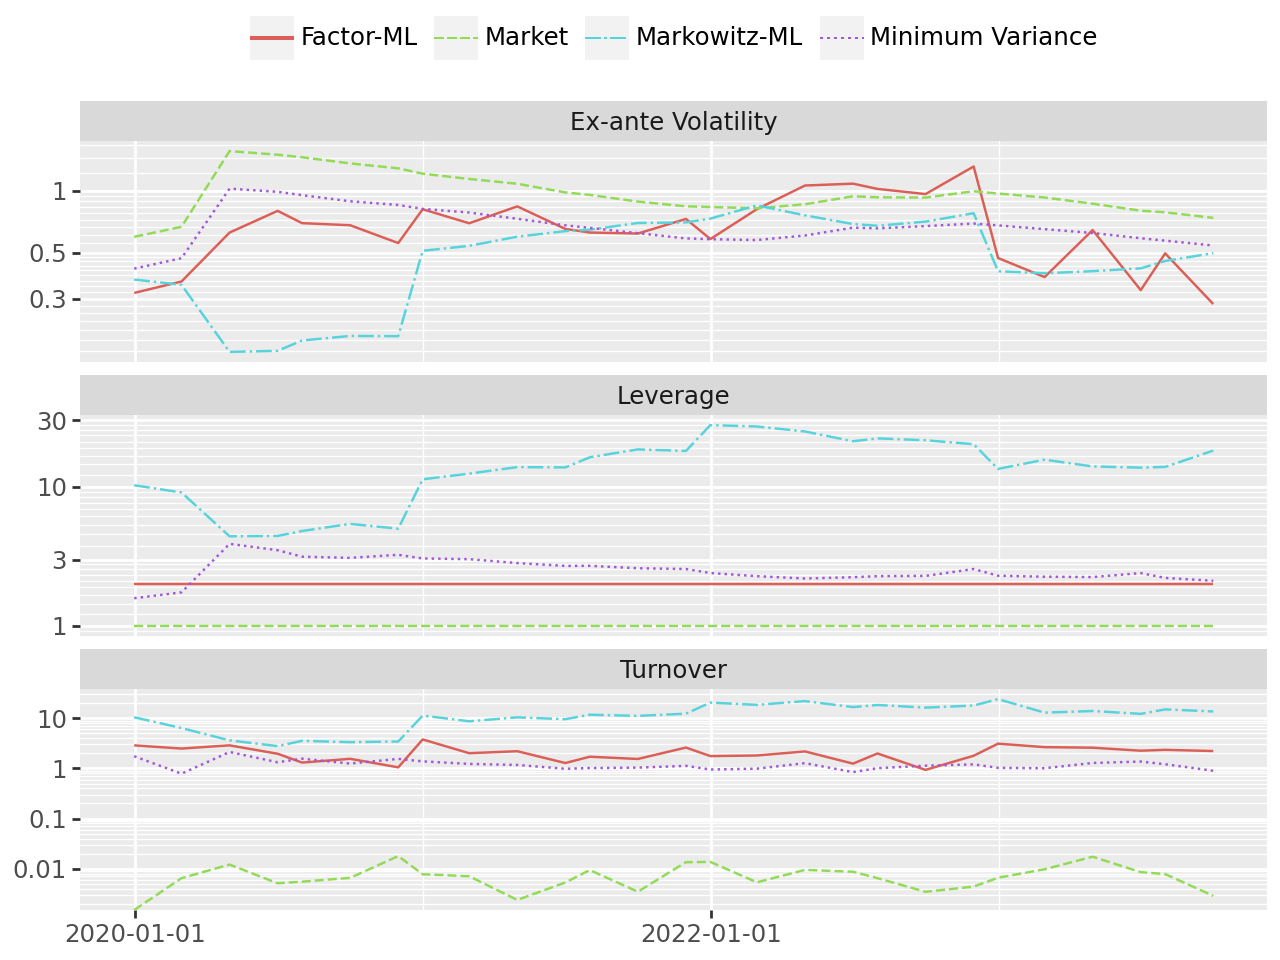

In [22]:
# --- 3. Beregn forventet porteføljerisiko ---
# Her kaldes din expected_risk_fun, som skal returnere en DataFrame med kolonnerne: 'type', 'eom' og 'pf_var'
pf_vars = expected_risk_fun(ws, dates=dates_oos, cov_list=barra_cov)
print("pf_vars columns:", pf_vars.columns)

# --- 4. Saml porteføljestatistikker ---
# Opret en ny kolonne 'eom' i pfs ud fra 'eom_ret' (her antages at eom = eom_ret - 1 måned)
pfs_stats = pfs.copy()
pfs_stats['eom'] = pfs_stats['eom_ret'] - pd.DateOffset(months=1)
pfs_stats = pfs_stats[['type', 'eom', 'inv', 'turnover']]
print("pfs_stats columns:", pfs_stats.columns)

# Merge pf_vars med pfs_stats på 'type' og 'eom'
comp_stats = pd.merge(pf_vars, pfs_stats, on=['type', 'eom'], how='inner')

# Filtrer for de relevante porteføljer (her er det de samme som i pf_order)
main_types = pf_order
comp_stats = comp_stats[comp_stats['type'].isin(main_types)]

# Udregn ex-ante volatilitet (e_sd) ud fra variansen (pf_var)
comp_stats['e_sd'] = np.sqrt(comp_stats['pf_var'] * 252)

# Fjern pf_var, da vi ikke skal plotte den
comp_stats = comp_stats.drop(columns=['pf_var'])

# --- 5. Transformér data til langt format ---
# Omform data fra bredt til langt format (pivot_longer i R svarer til melt i pandas)
comp_stats_long = comp_stats.melt(id_vars=['type', 'eom'],
                                   value_vars=['inv', 'turnover', 'e_sd'],
                                   var_name='name', value_name='value')

# Map variable-navne til læsevenlige betegnelser
name_mapping = {"e_sd": "Ex-ante Volatility", "turnover": "Turnover", "inv": "Leverage"}
comp_stats_long['name'] = comp_stats_long['name'].map(name_mapping)

# --- 6. Lav plottet med plotnine ---
plot_comp_stats = (
    ggplot(comp_stats_long, aes(x='eom', y='value', color='type', linetype='type'))
    + geom_line()
    + scale_y_log10()
    + labs(y="Value", x="")
    + facet_wrap('~name', scales="free_y", ncol=1)
    + theme(
          legend_position="top",
          legend_title=element_blank(),
          axis_title_x=element_blank(),
          axis_title_y=element_blank()
      )
)

# Vis plottet (i en Jupyter Notebook)
display(plot_comp_stats)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


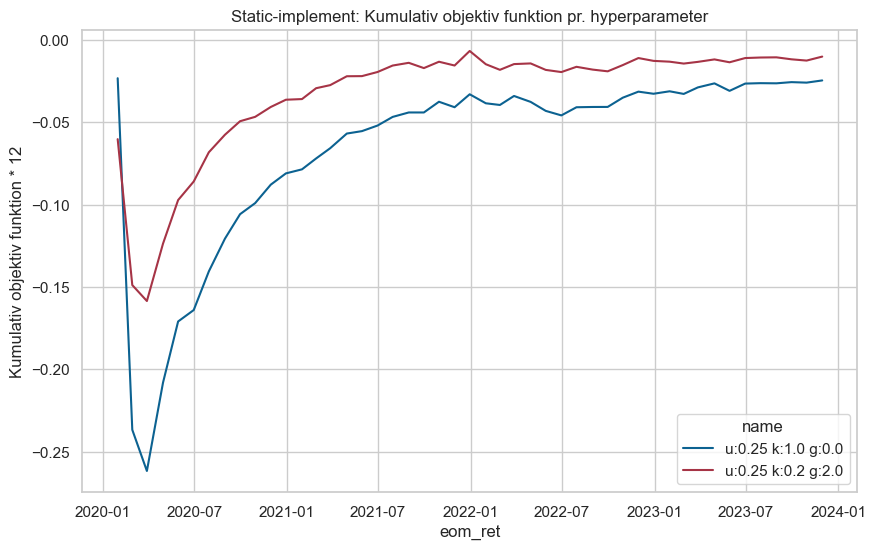

In [30]:
static = portfolio_choice_functions.static_implement(
    data_tc=chars,
    cov_list=barra_cov,
    lambda_list=lambda_list,
    rf=risk_free,              # Data
    wealth=wealth,
    mu=pf_set['mu'],
    gamma_rel=pf_set['gamma_rel'],  # Investor
    dates_full=dates_m1,
    dates_oos=dates_oos,
    dates_hp=dates_hp,
    hp_years=hp_years,          # Dates
    k_vec=settings['pf']['hps']['static']['k'],
    u_vec=settings['pf']['hps']['static']['u'],
    g_vec=settings['pf']['hps']['static']['g'],
    cov_type=settings['pf']['hps']['cov_type'],
    validation=None
)

In [31]:
static

{'hps':            inv  shorting  turnover         r        tc    eom_ret  hp_no    k  \
 0     0.602167  0.023467  0.444766 -0.000534  0.001407 2020-01-31      0  1.0   
 1     0.486646  0.063525  0.196633 -0.035702  0.000262 2020-02-29      0  1.0   
 2     0.457107  0.106561  0.108553 -0.024823  0.000070 2020-03-29      0  1.0   
 3     0.402759  0.166525  0.189540 -0.002663  0.000178 2020-04-30      0  1.0   
 4     0.347078  0.149425  0.074104 -0.000751  0.000041 2020-05-30      0  1.0   
 ...        ...       ...       ...       ...       ...        ...    ...  ...   
 1264  1.558910  0.538276  0.333172  0.002285  0.001513 2023-07-30     26  0.2   
 1265  1.536427  0.515927  0.320105 -0.000312  0.001540 2023-08-31     26  0.2   
 1266  1.591636  0.525289  0.381948 -0.020108  0.002115 2023-09-30     26  0.2   
 1267  1.698215  0.561790  0.361568 -0.013834  0.002197 2023-10-30     26  0.2   
 1268  1.783206  0.594410  0.444811  0.034985  0.002488 2023-11-30     26  0.2   
 
       